# Marketing Mix Modeling with Bayesian Methods

This notebook implements a Bayesian Marketing Mix Model (MMM) using PyMC. The model includes:
- Geometric adstock transformation for advertising carryover effects
- Trend and seasonality components
- Channel effectiveness evaluation
- ROI analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
import os

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load and Prepare Data

In [2]:
# Load data
data = pd.read_csv("MMM_test_data.csv")
data['start_of_week'] = pd.to_datetime(data['start_of_week'], format='%d-%m-%y')
# Identify channel columns
channel_cols = [col for col in data.columns if 'spend_channel' in col]
print(f"Modeling the following channels: {channel_cols}")

# Sort data by time to ensure proper temporal ordering
data = data.sort_values('start_of_week').reset_index(drop=True)

# Calculate week numbers from the earliest date
data['week_num'] = (data['start_of_week'] - data['start_of_week'].min()).dt.days // 7

# Examine the data
data.head()


Modeling the following channels: ['spend_channel_1', 'spend_channel_2', 'spend_channel_3', 'spend_channel_4', 'spend_channel_5', 'spend_channel_6', 'spend_channel_7']


## Visualize data

/home/coder/tmp/ipykernel_306489/3810372655.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


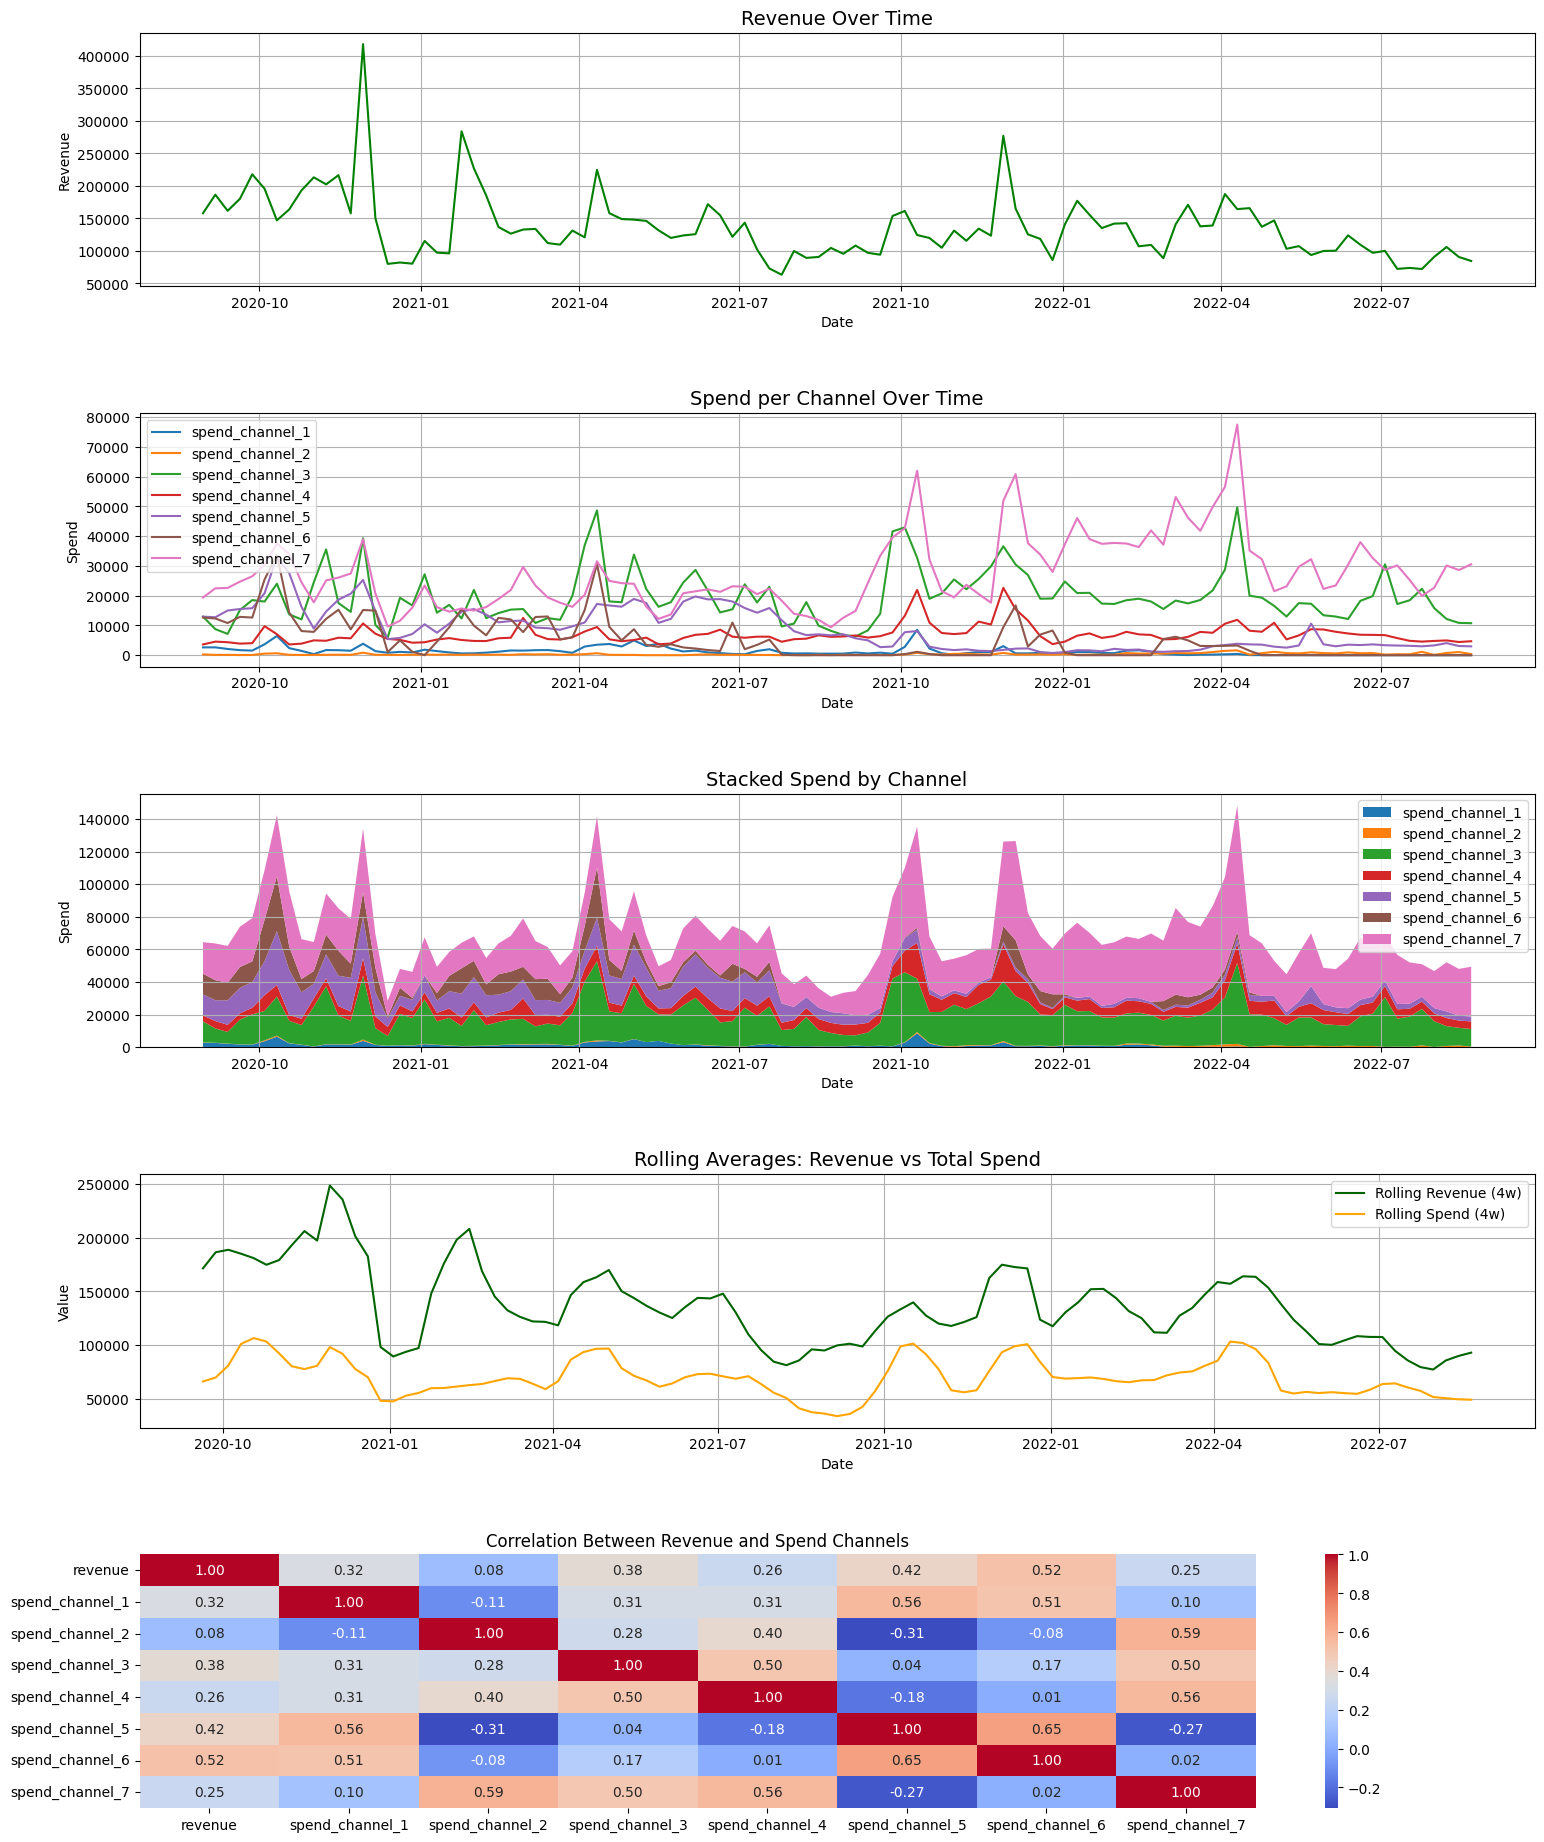

In [3]:
def generate_channel_visuals(data, channel_cols):
    """
    Generate comprehensive visualizations for marketing channel analysis.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing revenue and channel spend data.
    channel_cols : list
        Column names for different marketing spend channels.

    Returns
    -------
    pandas.DataFrame
        DataFrame with added analysis columns.
    """
    
    # Calculate total spend and rolling metrics
    data['total_spend'] = data[channel_cols].sum(axis=1)
    data['rolling_revenue'] = data['revenue'].rolling(window=4).mean()
    data['rolling_spend'] = data['total_spend'].rolling(window=4).mean()

    # Estimate ROI for each channel
    #for col in channel_cols:
       # revenue_alloc = data['revenue'] * (data[col] / data['total_spend'])
      #  data[f'roi_{col}'] = revenue_alloc / data[col]

    # Setup figure layout
    fig = plt.figure(figsize=(18, 28))
    gs = gridspec.GridSpec(6, 1, hspace=0.5)

    # 1. Revenue over time
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(data=data, x='start_of_week', y='revenue', ax=ax1, color='green')
    ax1.set_title('Revenue Over Time', fontsize=14)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Revenue')
    ax1.grid(True)

    # 2. Individual channel spend over time
    ax2 = fig.add_subplot(gs[1, 0])
    for col in channel_cols:
        sns.lineplot(data=data, x='start_of_week', y=col, label=col, ax=ax2)
    ax2.set_title('Spend per Channel Over Time', fontsize=14)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Spend')
    ax2.legend()
    ax2.grid(True)

    # 3. Stacked area chart of spend
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.stackplot(data['start_of_week'], [data[col] for col in channel_cols], labels=channel_cols)
    ax3.set_title('Stacked Spend by Channel', fontsize=14)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Spend')
    ax3.legend(loc='upper right')
    ax3.grid(True)

    # 4. Rolling averages of revenue vs total spend
    ax4 = fig.add_subplot(gs[3, 0])
    ax4.plot(data['start_of_week'], data['rolling_revenue'], label='Rolling Revenue (4w)', color='darkgreen')
    ax4.plot(data['start_of_week'], data['rolling_spend'], label='Rolling Spend (4w)', color='orange')
    ax4.set_title('Rolling Averages: Revenue vs Total Spend', fontsize=14)
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Value')
    ax4.legend()
    ax4.grid(True)

    # 5. Correlation heatmap
    ax5 = fig.add_subplot(gs[4, 0])
    corr = data[['revenue'] + channel_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax5)
    ax5.set_title('Correlation Between Revenue and Spend Channels')

    # # 6. ROI bar chart (mean ROI per channel)
    # ax6 = fig.add_subplot(gs[5, 0])
    # roi_means = data[[f'roi_{col}' for col in channel_cols]].mean()
    # sns.barplot(x=roi_means.values, y=roi_means.index, ax=ax6, palette='viridis')
    # ax6.set_title('Average ROI by Channel', fontsize=14)
    # ax6.set_xlabel('ROI')
    # ax6.set_ylabel('Channel')
    # ax6.grid(True, axis='x')

    # Final layout tweaks
    plt.tight_layout()
    plt.show()

    return data

df = generate_channel_visuals(data, channel_cols)

## Build Bayesian MMM Model

In [4]:
def build_mmm_model_differentAdstoc_TimingImpact(data, channel_cols):
    """
    Constructs and samples a Bayesian Marketing Mix Model (MMM) using PyMC, where each advertising spend channel 
    is modeled with its own adstock configuration and distinct timing impacts. The model assumes no saturation effects 
    and accounts for different advertising patterns across channels, such as immediate or delayed effects, 
    varying decay rates, and the presence of carryover effects.

    Parameters:
    - data (pd.DataFrame): A dataset containing time-series data of marketing spend and revenue, with at least 
      the columns 'week_num' and 'revenue', and additional columns for each spend channel.
    - channel_cols (list): A list of column names corresponding to the different advertising spend channels.

    Returns:
    - mmm (pm.Model): The constructed PyMC model object representing the MMM.
    - trace (InferenceData): The posterior distribution samples obtained from the model.
    - channel_data (dict): A dictionary containing the standardized spend data for each channel, 
      along with the mean and standard deviation values.
    - revenue_mean (float): The mean of the revenue data.
    - revenue_std (float): The standard deviation of the revenue data.
    - decay_rates (dict): A dictionary with the decay rates for each spend channel, sampled from the posterior.
    - channel_configs (dict): The configuration of adstock types, decay priors, lags, and timing impacts 
      for each spend channel.

    Model Highlights:
    - Channel-specific Adstock Models: Each channel is modeled with its own adstock mechanism, which can vary 
      between 'geometric', 'weibull', 'delayed', and 'flexible_decay' types. The adstock models capture the 
      decaying effect of advertising spend over time.
    - Timing Impact: The model includes different timing impacts such as 'immediate_only', 'immediate_with_carryover', 
      'delayed_peak', and 'multi_phase'. This allows for modeling both short-term and long-term effects of advertising.
    - Seasonality and Trend Components: The model includes seasonality and trend components to capture 
      cyclical and time-dependent effects on revenue.
    - Bayesian Inference: The model uses PyMC to sample from the posterior distribution of the model parameters, 
      providing uncertainty quantification for the estimated effects.
    """
    
    # Prepare time component for seasonality
    n_weeks = len(data)
    week_num = np.array(data['week_num'])
    
    # Standardize the input data for better convergence
    revenue = np.array(data['revenue'])
    revenue_mean = revenue.mean()
    revenue_std = revenue.std()
    revenue_standardized = (revenue - revenue_mean) / revenue_std
    
    # Standardize channel spend
    channel_data = {}
    for channel in channel_cols:
        channel_spend = np.array(data[channel])
        mean = channel_spend.mean()
        std = channel_spend.std()
        if std > 0:
            standardized = (channel_spend - mean) / std
        else:
            standardized = channel_spend
            std = 1.0
        channel_data[channel] = {'standardized': standardized, 'mean': mean, 'std': std}
    
    # Define channel-specific adstock configurations based on analysis
    channel_configs = {
        'spend_channel_1': {
            'adstock_type': 'geometric',
            'decay_prior': (3, 9),  # Beta prior favoring lower values (0.3-0.4)
            'lag': 0,
            'timing_impact': 'immediate_only',  # Short-term effects only
        },
        'spend_channel_2': {
            'adstock_type': 'geometric',
            'decay_prior': (2, 8),  # Beta prior favoring lower values (0.2-0.4)
            'lag': 0,
            'timing_impact': 'immediate_only',  # Short-term effects only
        },
        'spend_channel_3': {
            'adstock_type': 'geometric',
            'decay_prior': (6, 3),  # Beta prior favoring higher values (0.6-0.8)
            'lag': 0,
            'timing_impact': 'immediate_with_carryover',  # Strong immediate with medium carryover
        },
        'spend_channel_4': {
            'adstock_type': 'geometric',
            'decay_prior': (5, 3),  # Beta prior for medium decay (0.5-0.7)
            'lag': 0,
            'timing_impact': 'balanced',  # Balanced immediate and carryover effects
        },
        'spend_channel_5': {
            'adstock_type': 'flexible_decay',
            'decay_prior': (5, 3),  # Base decay rate
            'lag': 1,
            'timing_impact': 'delayed_peak',  # Delayed peak with extended tail
        },
        'spend_channel_6': {
            'adstock_type': 'delayed',
            'decay_prior': (4, 4),  # Medium decay after delay
            'lag': 2,  # Longer lag for this channel,
            'timing_impact': 'delayed_peak_short',  # Delayed peak followed by fast decay
        },
        'spend_channel_7': {
            'adstock_type': 'weibull',
            'decay_prior': (6, 3),  # Higher decay for sustained effects
            'lag': 0,
            'timing_impact': 'multi_phase',  # Both immediate impact and extended effects
        }
    }
    
    # Build the PyMC model
    with pm.Model() as mmm:
        # Channel-specific parameters and effects
        decay_rates = {}
        shape_params = {}  # For Weibull adstock
        timing_params = {}
        channel_coefs = {}
        channel_effects = pt.zeros_like(pt.as_tensor_variable(revenue_standardized))
        
        # Process each channel with its specific model
        for ch in channel_cols:
   
            config = channel_configs.get(ch)
            if config is None:
                print(f"Warning: Channel config not found for {ch}. Using default config.")
                # Use default config if channel not in configs
                config = {
                    'adstock_type': 'geometric',
                    'decay_prior': (3, 3),
                    'lag': 0,
                    'timing_impact': 'immediate_only'
                }
            print(f"Using config for {ch}: {config}")
            # Apply lag if specified
            std_spend = channel_data[ch]['standardized'].astype(np.float64)
            if config['lag'] > 0:
                # Shift the spend data by lag periods
                lag = config['lag']
                lagged_spend = np.zeros_like(std_spend)
                lagged_spend[lag:] = std_spend[:-lag] if lag < len(std_spend) else np.zeros(len(std_spend) - lag)
                std_spend = lagged_spend
            
            # Define decay rate with channel-specific prior
            alpha, beta = config['decay_prior']
            decay_rates[ch] = pm.Beta(f"decay_rate_{ch}", alpha=alpha, beta=beta)
            
            # Initialize adstock array
            adstocked_symbolic = pt.zeros_like(pt.as_tensor_variable(std_spend))
            
            # Apply different adstock models based on channel configuration
            if config['adstock_type'] == 'geometric':
                # Standard geometric adstock
                for t in range(len(std_spend)):
                    if t == 0:
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], std_spend[t])
                    else:
                        prev_adstock = adstocked_symbolic[t-1]
                        current_adstock = std_spend[t] + decay_rates[ch] * prev_adstock
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], current_adstock)
            
            elif config['adstock_type'] == 'weibull':
                # Weibull adstock for more complex decay patterns
                shape_params[ch] = pm.Gamma(f"shape_{ch}", alpha=2, beta=1)
                
                for t in range(len(std_spend)):
                    if t == 0:
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], std_spend[t])
                    else:
                         # Create weights for previous periods using PyTensor operations
                        weighted_sum = std_spend[t]  # Start with current period
                        
                        # Compute weights for each previous period using PyTensor
                        for i in range(t):
                            # Calculate Weibull decay for period i
                            # t-i is the age of the effect
                            age = t - i
                            # Use pt.exp and pt.power for PyTensor operations
                            weight = pt.exp(-(pt.power(age / decay_rates[ch], shape_params[ch])))
                            weighted_sum += weight * std_spend[i]
                        
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], weighted_sum)

            
            elif config['adstock_type'] == 'delayed':
                # Delayed response model
                delay_param = pm.Gamma(f"delay_{ch}", alpha=2, beta=1)
                
                for t in range(len(std_spend)):
                    if t == 0:
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], std_spend[t])
                    else:
                        # Delayed adstock model (peak effect comes after delay)
                        prev_adstock = adstocked_symbolic[t-1]
                        delay_factor = pt.exp(-(t / delay_param)**2)
                        current_adstock = std_spend[t] + (decay_rates[ch] * prev_adstock * (1 - delay_factor))
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], current_adstock)
            
            elif config['adstock_type'] == 'flexible_decay':
                # Time-varying decay rate
                time_factor = pm.Beta(f"time_factor_{ch}", alpha=2, beta=2)
                
                for t in range(len(std_spend)):
                    if t == 0:
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], std_spend[t])
                    else:
                        # Decay rate changes over time
                        scaled_t = t / len(std_spend)
                        dynamic_decay = decay_rates[ch] * (1 - time_factor * scaled_t)
                        prev_adstock = adstocked_symbolic[t-1]
                        current_adstock = std_spend[t] + dynamic_decay * prev_adstock
                        adstocked_symbolic = pt.set_subtensor(adstocked_symbolic[t], current_adstock)
            
            
            # Initialize final effect that will be modified by timing impact
            final_effect = pt.zeros_like(pt.as_tensor_variable(std_spend))
            
            # Apply different timing impact models
            if config['timing_impact'] == 'immediate_only':
                # Short-term effects only - no modification needed
                timing_params[ch] = {'type': 'immediate_only'}
                final_effect = adstocked_symbolic
                
            elif config['timing_impact'] == 'immediate_with_carryover':
                # Strong immediate with medium carryover - split into immediate and carryover
                immediate_weight = pm.Beta(f"immediate_weight_{ch}", alpha=3, beta=2)  # Favor immediate (0.5-0.8)
                timing_params[ch] = {'type': 'immediate_with_carryover', 'immediate_weight': immediate_weight}
                
                immediate_effect = std_spend  # Direct effect without adstock
                carryover_effect = adstocked_symbolic
                
                final_effect = immediate_weight * immediate_effect + (1 - immediate_weight) * carryover_effect
                
            elif config['timing_impact'] == 'balanced':
                # Balanced immediate and carryover effects
                timing_params[ch] = {'type': 'balanced'}
                final_effect = adstocked_symbolic  # Standard adstock already balances these
                
            elif config['timing_impact'] == 'delayed_peak':
                # Delayed peak with extended tail
                peak_week = pm.Gamma(f"peak_week_{ch}", alpha=2, beta=0.5)  # Peak around 4 weeks
                peak_spread = pm.HalfNormal(f"peak_spread_{ch}", sigma=2)  # How spread out the peak is
                timing_params[ch] = {'type': 'delayed_peak', 'peak_week': peak_week, 'peak_spread': peak_spread}
                
                # Apply peak timing modifier to each time step
                for t in range(len(std_spend)):
                    # Create bell curve around peak time
                    time_factor = pt.exp(-((t - peak_week) / peak_spread)**2)
                    
                    # Combine immediate spend with peak-modified adstock
                    current_effect = std_spend[t] + time_factor * adstocked_symbolic[t]
                    final_effect = pt.set_subtensor(final_effect[t], current_effect)
                
            elif config['timing_impact'] == 'delayed_peak_short':
                # Delayed peak followed by fast decay
                peak_week = pm.Gamma(f"peak_week_{ch}", alpha=2, beta=1)  # Peak around 2 weeks
                decay_after_peak = pm.Beta(f"decay_after_peak_{ch}", alpha=2, beta=5)  # Fast decay (0.1-0.3)
                timing_params[ch] = {'type': 'delayed_peak_short', 'peak_week': peak_week, 'decay_after_peak': decay_after_peak}
                
                # Calculate effect with delayed peak and fast decay
                for t in range(len(std_spend)):
                    if t == 0:
                        current_effect = std_spend[t]
                    else:
                        # Calculate how far we are from peak
                        time_to_peak = pt.maximum(0, peak_week - t)
                        after_peak = pt.switch(t > peak_week, 1, 0)
                        
                        # Before peak: accumulate effect
                        # At/after peak: apply faster decay
                        if after_peak:
                            decay = decay_after_peak
                        else:
                            decay = decay_rates[ch]
                            
                        prev_effect = final_effect[t-1]
                        current_effect = std_spend[t] + decay * prev_effect
                    
                    final_effect = pt.set_subtensor(final_effect[t], current_effect)
                
            elif config['timing_impact'] == 'multi_phase':
                # Both immediate impact and extended effects
                immediate_coef = pm.Beta(f"immediate_coef_{ch}", alpha=3, beta=2)  # 0.5-0.8 range
                long_term_coef = pm.Beta(f"long_term_coef_{ch}", alpha=2, beta=3)  # 0.2-0.5 range
                timing_params[ch] = {
                    'type': 'multi_phase',
                    'immediate_coef': immediate_coef,
                    'long_term_coef': long_term_coef
                }
                
                # Calculate immediate and long-term effects
                immediate_effect = std_spend  # Direct effect
                long_term_effect = adstocked_symbolic  # Adstocked effect
                
                # Combine phases with their respective coefficients
                final_effect = immediate_coef * immediate_effect + long_term_coef * long_term_effect

            
            # Apply channel coefficient directly to adstocked values without saturation
            channel_coefs[ch] = pm.HalfNormal(f"coef_{ch}", sigma=1)
            effect = channel_coefs[ch] * final_effect
            
            # Store deterministic variables for analysis
            pm.Deterministic(f"adstock_{ch}", adstocked_symbolic)
            pm.Deterministic(f"effect_{ch}", effect)
            
            # Add to total effect
            channel_effects += effect
        
        # Trend component
        scaled_time = week_num / n_weeks
        trend_coef = pm.Normal("trend_coef", mu=0, sigma=1)
        trend = trend_coef * scaled_time
        
        # Seasonality component
        n_harmonics = 4
        seasonality_features = []
        for h in range(1, n_harmonics + 1):
            period = 52.0  # Annual seasonality
            seasonality_features.extend([
                np.sin(2 * np.pi * h * week_num / period),
                np.cos(2 * np.pi * h * week_num / period)
            ])
        
        seasonality_features = np.column_stack(seasonality_features)
        season_coefs = pm.Normal("season_coefs", mu=0, sigma=0.5, shape=seasonality_features.shape[1])
        seasonality = pm.math.dot(seasonality_features, season_coefs)
        
        # Intercept component
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        
        # Full model
        mu = intercept + trend + seasonality + channel_effects
        
        # Likelihood
        sigma = pm.HalfNormal('sigma', sigma=1)
        pm.Normal('likelihood', mu=mu, sigma=sigma, observed=revenue_standardized)
        
        # Sample from the posterior
        trace = pm.sample(
            draws=2000, 
            tune=1000,
            chains=4,
            return_inferencedata=True,
            target_accept=0.95
        )
       # pm.summary(trace)
       # pm.plot_posterior(trace)
    
    return mmm, trace, channel_data, revenue_mean, revenue_std, decay_rates, channel_configs

In [5]:
mmm, trace, channel_data, revenue_mean, revenue_std, decay_rates, channel_configs = build_mmm_model_differentAdstoc_TimingImpact(data, channel_cols=channel_cols)


Using config for spend_channel_1: {'adstock_type': 'geometric', 'decay_prior': (3, 9), 'lag': 0, 'timing_impact': 'immediate_only'}
Using config for spend_channel_2: {'adstock_type': 'geometric', 'decay_prior': (2, 8), 'lag': 0, 'timing_impact': 'immediate_only'}
Using config for spend_channel_3: {'adstock_type': 'geometric', 'decay_prior': (6, 3), 'lag': 0, 'timing_impact': 'immediate_with_carryover'}


Using config for spend_channel_4: {'adstock_type': 'geometric', 'decay_prior': (5, 3), 'lag': 0, 'timing_impact': 'balanced'}
Using config for spend_channel_5: {'adstock_type': 'flexible_decay', 'decay_prior': (5, 3), 'lag': 1, 'timing_impact': 'delayed_peak'}
Using config for spend_channel_6: {'adstock_type': 'delayed', 'decay_prior': (4, 4), 'lag': 2, 'timing_impact': 'delayed_peak_short'}
Using config for spend_channel_7: {'adstock_type': 'weibull', 'decay_prior': (6, 3), 'lag': 0, 'timing_impact': 'multi_phase'}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [decay_rate_spend_channel_1, coef_spend_channel_1, decay_rate_spend_channel_2, coef_spend_channel_2, decay_rate_spend_channel_3, immediate_weight_spend_channel_3, coef_spend_channel_3, decay_rate_spend_channel_4, coef_spend_channel_4, decay_rate_spend_channel_5, time_factor_spend_channel_5, peak_week_spend_channel_5, peak_spread_spend_channel_5, coef_spend_channel_5, decay_rate_spend_channel_6, delay_spend_channel_6, peak_week_spend_channel_6, decay_after_peak_spend_channel_6, coef_spend_channel_6, decay_rate_spend_channel_7, shape_spend_channel_7, immediate_coef_spend_channel_7, long_term_coef_spend_channel_7, coef_spend_channel_7, trend_coef, season_coefs, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1826 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


## compare prior and posterior

In [6]:
def compare_prior_posterior(mmm, trace, revenue_mean, revenue_std, channel_cols, channel_configs):
    """
    Compare prior and posterior distributions for the MMM model parameters.
    
    Parameters:
    - mmm (pm.Model): The PyMC model object
    - trace (InferenceData): The posterior samples
    - channel_cols (list): List of channel column names
    - channel_configs (dict): Dictionary of channel configurations
    
    Returns:
    - prior_stats (dict): Statistics for prior distributions
    - posterior_stats (dict): Statistics for posterior distributions
    - summary_df (pd.DataFrame): Summary dataframe comparing prior and posterior
    """
    
    # Sample from prior distributions
    with mmm:
        prior_samples = pm.sample_prior_predictive(samples=1000)
    
    # Create figures directory if it doesn't exist
    if not os.path.exists('figures'):
        os.makedirs('figures')
    
    # Initialize dictionaries to store results
    prior_stats = {}
    posterior_stats = {}
    
    # Analyze channel coefficients
    plt.figure(figsize=(15, 10))
    for i, ch in enumerate(channel_cols):
        # Extract prior samples for this channel's coefficient
        print(type(prior_samples))
        print(list(prior_samples.keys()))
        prior_coef = prior_samples.prior[f"coef_{ch}"].values.flatten()
        prior_mean = prior_coef.mean()
        prior_std = prior_coef.std()
        prior_hdi = np.percentile(prior_coef, [2.5, 97.5])
        
        # Extract posterior samples
        posterior_coef = trace.posterior[f"coef_{ch}"].values.flatten()
        post_mean = posterior_coef.mean()
        post_std = posterior_coef.std()
        post_hdi = np.percentile(posterior_coef, [2.5, 97.5])
        
        # Store statistics
        prior_stats[f"coef_{ch}"] = {"mean": prior_mean, "std": prior_std, "hdi": prior_hdi}
        posterior_stats[f"coef_{ch}"] = {"mean": post_mean, "std": post_std, "hdi": post_hdi}
        
        # Plot distributions
        plt.subplot(3, 3, i+1)
        sns.kdeplot(prior_coef, label=f"Prior", color="blue", fill=True, alpha=0.3)
        sns.kdeplot(posterior_coef, label=f"Posterior", color="red", fill=True, alpha=0.3)
        plt.axvline(prior_mean, color="blue", linestyle="--", label=f"Prior mean: {prior_mean:.2f}")
        plt.axvline(post_mean, color="red", linestyle="--", label=f"Post mean: {post_mean:.2f}")
        plt.title(f"Channel {ch} Coefficient")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig('figures/channel_coefficients_prior_vs_posterior.png')
    plt.close()
    
    # Analyze decay rates
    plt.figure(figsize=(15, 10))
    for i, ch in enumerate(channel_cols):
        # Extract prior samples for decay rate
        prior_decay = prior_samples.prior[f"decay_rate_{ch}"].values.flatten()
        prior_mean = prior_decay.mean()
        prior_std = prior_decay.std()
        prior_hdi = np.percentile(prior_decay, [2.5, 97.5])
        
        # Extract posterior samples
        posterior_decay = trace.posterior[f"decay_rate_{ch}"].values.flatten()
        post_mean = posterior_decay.mean()
        post_std = posterior_decay.std()
        post_hdi = np.percentile(posterior_decay, [2.5, 97.5])
        
        # Store statistics
        prior_stats[f"decay_rate_{ch}"] = {"mean": prior_mean, "std": prior_std, "hdi": prior_hdi}
        posterior_stats[f"decay_rate_{ch}"] = {"mean": post_mean, "std": post_std, "hdi": post_hdi}
        
        # Plot distributions
        plt.subplot(3, 3, i+1)
        sns.kdeplot(prior_decay, label=f"Prior", color="blue", fill=True, alpha=0.3)
        sns.kdeplot(posterior_decay, label=f"Posterior", color="red", fill=True, alpha=0.3)
        plt.axvline(prior_mean, color="blue", linestyle="--", label=f"Prior mean: {prior_mean:.2f}")
        plt.axvline(post_mean, color="red", linestyle="--", label=f"Post mean: {post_mean:.2f}")
        plt.title(f"Channel {ch} Decay Rate")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig('figures/decay_rates_prior_vs_posterior.png')
    plt.close()
    
    # Analyze intercept, trend, and sigma
    plt.figure(figsize=(15, 5))
    for i, param in enumerate(['intercept', 'trend_coef', 'sigma']):
        # Extract prior samples
        prior_param = prior_samples.prior[param].values.flatten()
        prior_mean = prior_param.mean()
        prior_std = prior_param.std()
        prior_hdi = np.percentile(prior_param, [2.5, 97.5])
        
        # Extract posterior samples
        posterior_param = trace.posterior[param].values.flatten()
        post_mean = posterior_param.mean()
        post_std = posterior_param.std()
        post_hdi = np.percentile(posterior_param, [2.5, 97.5])
        
        # Store statistics
        prior_stats[param] = {"mean": prior_mean, "std": prior_std, "hdi": prior_hdi}
        posterior_stats[param] = {"mean": post_mean, "std": post_std, "hdi": post_hdi}
        
        # Plot distributions
        plt.subplot(1, 3, i+1)
        sns.kdeplot(prior_param, label=f"Prior", color="blue", fill=True, alpha=0.3)
        sns.kdeplot(posterior_param, label=f"Posterior", color="red", fill=True, alpha=0.3)
        plt.axvline(prior_mean, color="blue", linestyle="--", label=f"Prior mean: {prior_mean:.2f}")
        plt.axvline(post_mean, color="red", linestyle="--", label=f"Post mean: {post_mean:.2f}")
        plt.title(f"{param}")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig('figures/model_params_prior_vs_posterior.png')
    plt.close()
    
    # Prior vs posterior predictive check
    with mmm:
        # Get prior predictive samples for revenue
        prior_pred = pm.sample_prior_predictive(samples=100)
        # Get posterior predictive samples for revenue
        posterior_pred = pm.sample_posterior_predictive(trace, var_names=['likelihood'])
    
    # Convert standardized values back to original scale
    obs_revenue = mmm.observed_RVs[0].eval() * revenue_std + revenue_mean
    
    # Print information about the data structures
   # print("Prior pred structure:", type(prior_pred))
   # print("Prior pred keys:", list(prior_pred.keys()))
   # print("Posterior pred structure:", type(posterior_pred))
    #print("Posterior pred keys:", list(posterior_pred.keys()))
    
    # Find and process prior predictive samples
    try:
        # For PyMC>=4 structures
        if hasattr(prior_pred, 'prior_predictive'):
            print("Prior predictive keys:", list(prior_pred.prior_predictive.keys()))
            
            # Try finding the likelihood variable
            if 'likelihood' in prior_pred.prior_predictive:
                prior_data = prior_pred.prior_predictive['likelihood']
            else:
                # Try to find another suitable variable
                for key in prior_pred.prior_predictive:
                    if key not in ['intercept', 'trend_coef', 'sigma'] and not key.startswith(('coef_', 'decay_rate_')):
                       # print(f"Using '{key}' for prior predictive")
                        prior_data = prior_pred.prior_predictive[key]
                        break
        # For older PyMC structures
        else:
            if 'likelihood' in prior_pred:
                prior_data = prior_pred['likelihood']
            else:
                # Try finding another suitable variable
                for key in prior_pred:
                    if key not in ['prior', 'intercept', 'trend_coef', 'sigma'] and not key.startswith(('coef_', 'decay_rate_')):
                        #print(f"Using '{key}' for prior predictive")
                        prior_data = prior_pred[key]
                        break
        
        # Convert to numpy arrays if needed
        if hasattr(prior_data, 'values'):
            prior_data = prior_data.values
        
        # Scale the data
        prior_revenue = prior_data * revenue_std + revenue_mean
        
    except Exception as e:
        print(f"Error processing prior predictive samples: {e}")
        # Create dummy data so the rest of the function still works
        prior_revenue = np.zeros((1, len(obs_revenue)))
    
    # Find and process posterior predictive samples
    try:
        # Find the right key in posterior predictive samples
        if 'likelihood' in posterior_pred:
            post_data = posterior_pred['likelihood']
        else:
            # Try finding another suitable variable
            for key in posterior_pred:
                if key not in ['intercept', 'trend_coef', 'sigma'] and not key.startswith(('coef_', 'decay_rate_')):
                    #print(f"Using '{key}' for posterior predictive")
                    post_data = posterior_pred[key]
                    break
        
        # Convert to numpy arrays if needed
        if hasattr(post_data, 'values'):
            post_data = post_data.values
        
        # Scale the data
        post_revenue = post_data * revenue_std + revenue_mean
        
    except Exception as e:
        print(f"Error processing posterior predictive samples: {e}")
        # Create dummy data so the rest of the function still works
        post_revenue = np.zeros((1, len(obs_revenue)))
    
    # Plot predictive checks - handle different dimensions properly
    plt.figure(figsize=(12, 6))
    plt.plot(obs_revenue, 'k-', label='Observed Revenue', linewidth=2)
    
    # Debug information about the arrays
   #print(f"Prior revenue shape: {prior_revenue.shape}")
    #print(f"Post revenue shape: {post_revenue.shape}")
    
    # Plot prior predictive samples - handle different data structures
    try:
        if len(prior_revenue.shape) == 1:
            # Single sample case
            plt.plot(prior_revenue, color='blue', alpha=0.1)
        elif len(prior_revenue.shape) == 2:
            # Multiple samples case with shape (n_samples, n_timepoints)
            for i in range(min(20, prior_revenue.shape[0])):
                plt.plot(prior_revenue[i], color='blue', alpha=0.1)
        elif len(prior_revenue.shape) == 3:
            # Case with extra dimensions like (chains, samples, timepoints)
            for i in range(min(5, prior_revenue.shape[0])):
                for j in range(min(4, prior_revenue.shape[1])):
                    plt.plot(prior_revenue[i, j], color='blue', alpha=0.1)
    except Exception as e:
        print(f"Error plotting prior revenue: {e}")
    
    # Plot posterior predictive samples - handle different data structures
    try:
        if len(post_revenue.shape) == 1:
            # Single sample case
            plt.plot(post_revenue, color='red', alpha=0.1)
        elif len(post_revenue.shape) == 2:
            # Multiple samples case with shape (n_samples, n_timepoints)
            for i in range(min(20, post_revenue.shape[0])):
                plt.plot(post_revenue[i], color='red', alpha=0.1)
        elif len(post_revenue.shape) == 3:
            # Case with extra dimensions like (chains, samples, timepoints)
            for i in range(min(5, post_revenue.shape[0])):
                for j in range(min(4, post_revenue.shape[1])):
                    plt.plot(post_revenue[i, j], color='red', alpha=0.1)
    except Exception as e:
        print(f"Error plotting posterior revenue: {e}")
    
    plt.title('Prior vs Posterior Predictive Check')
    plt.ylabel('Revenue')
    plt.xlabel('Week')
    
    # Add legend with colored patches
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.3, label='Prior Predictions'),
        Patch(facecolor='red', alpha=0.3, label='Posterior Predictions'),
        Patch(facecolor='black', label='Observed Data')
    ]
    plt.legend(handles=legend_elements)
    
    plt.savefig('figures/prior_vs_posterior_predictive_check.png')
    plt.close()
    
    # Prepare summary DataFrame for easier reporting
    summary_data = []
    
    for param in prior_stats.keys():
        pr = prior_stats[param]
        po = posterior_stats[param]
        uncertainty_reduction = (pr["std"] - po["std"]) / pr["std"] * 100 if pr["std"] > 0 else 0
        
        summary_data.append({
            "Parameter": param,
            "Prior_Mean": pr["mean"],
            "Prior_Std": pr["std"],
            "Prior_95%_HDI": f"({pr['hdi'][0]:.3f}, {pr['hdi'][1]:.3f})",
            "Posterior_Mean": po["mean"],
            "Posterior_Std": po["std"],
            "Posterior_95%_HDI": f"({po['hdi'][0]:.3f}, {po['hdi'][1]:.3f})",
            "Change_in_Mean": po["mean"] - pr["mean"],
            "Uncertainty_Reduction_%": uncertainty_reduction
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('prior_vs_posterior_summary.csv', index=False)
    
    return prior_stats, posterior_stats, summary_df

Sampling: [coef_spend_channel_1, coef_spend_channel_2, coef_spend_channel_3, coef_spend_channel_4, coef_spend_channel_5, coef_spend_channel_6, coef_spend_channel_7, decay_after_peak_spend_channel_6, decay_rate_spend_channel_1, decay_rate_spend_channel_2, decay_rate_spend_channel_3, decay_rate_spend_channel_4, decay_rate_spend_channel_5, decay_rate_spend_channel_6, decay_rate_spend_channel_7, delay_spend_channel_6, immediate_coef_spend_channel_7, immediate_weight_spend_channel_3, intercept, likelihood, long_term_coef_spend_channel_7, peak_spread_spend_channel_5, peak_week_spend_channel_5, peak_week_spend_channel_6, season_coefs, shape_spend_channel_7, sigma, time_factor_spend_channel_5, trend_coef]


<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']
<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']
<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']
<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']
<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']
<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']
<class 'arviz.data.inference_data.InferenceData'>
['prior', 'prior_predictive', 'observed_data']


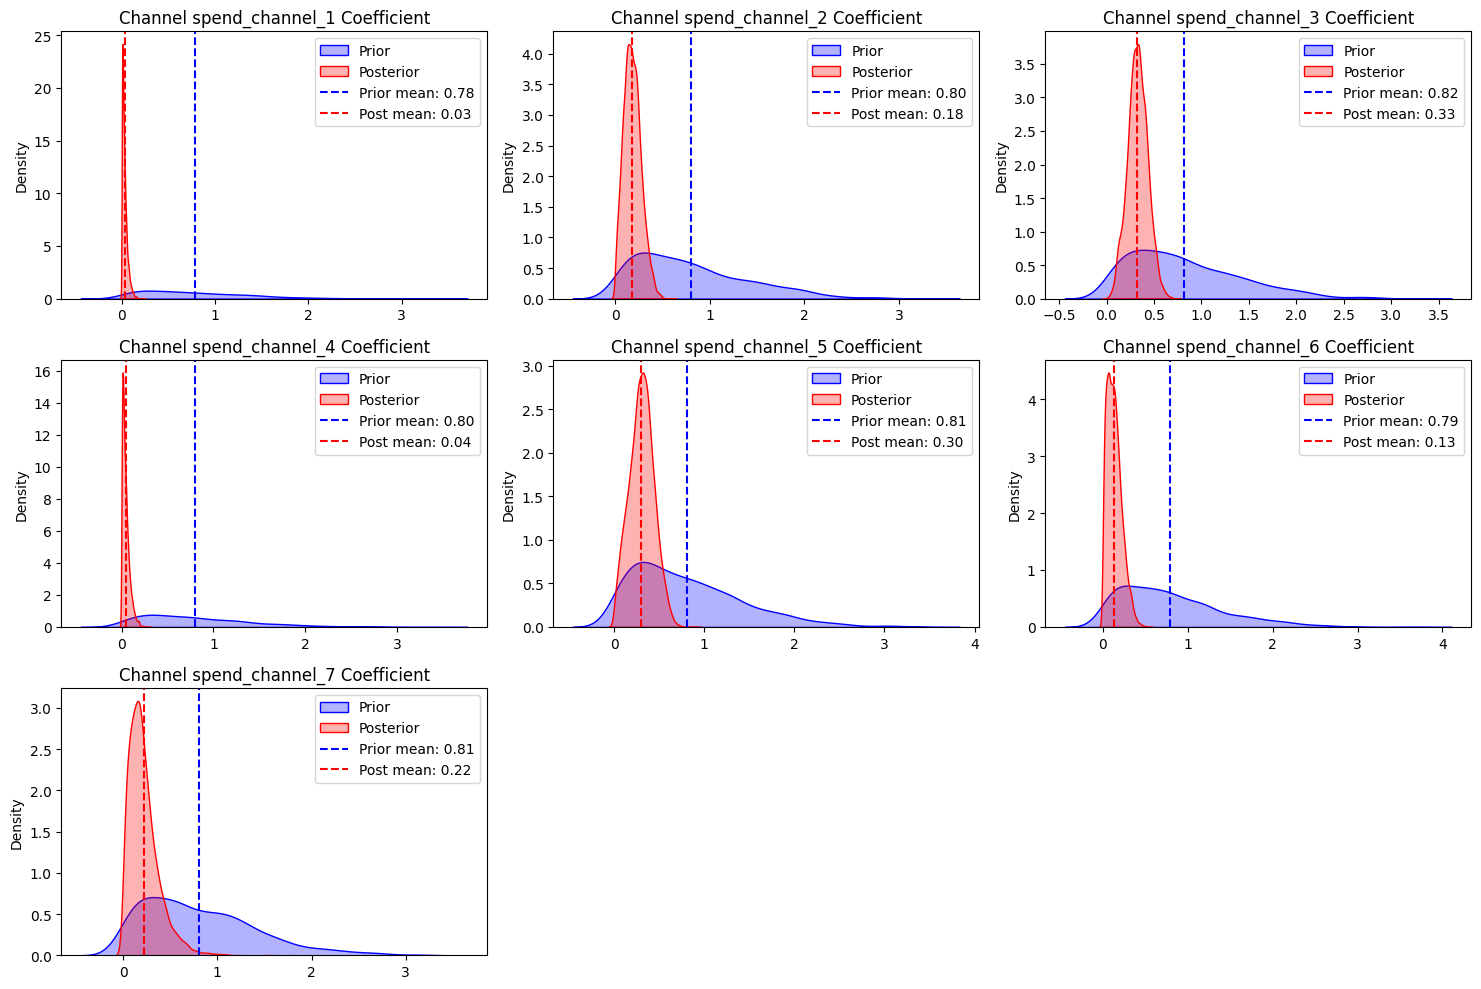

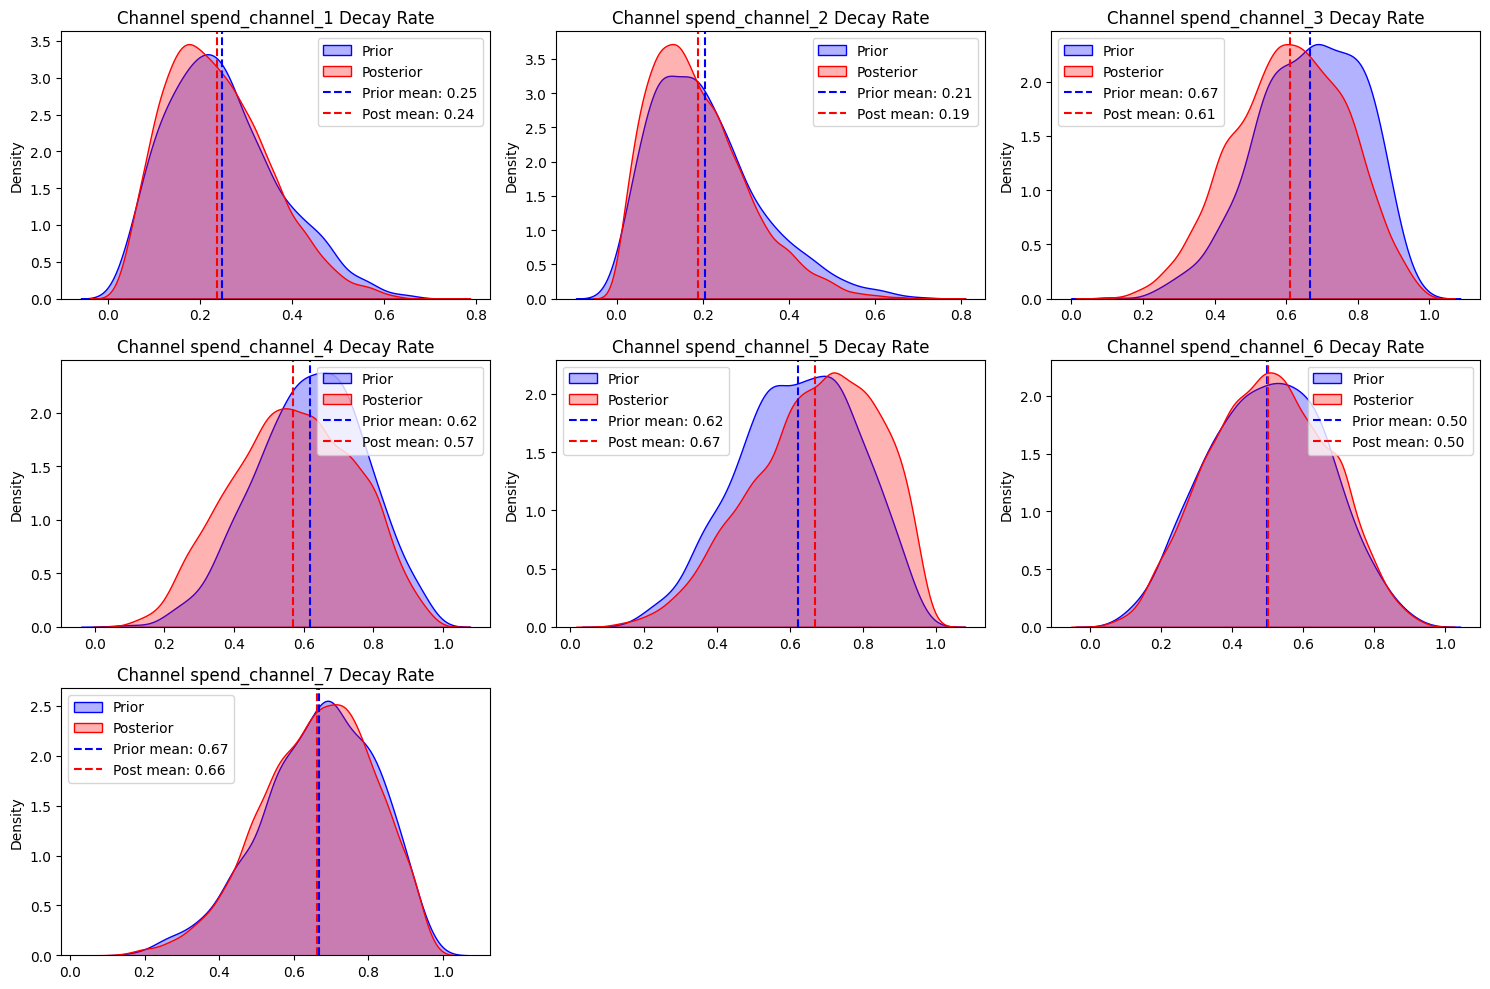

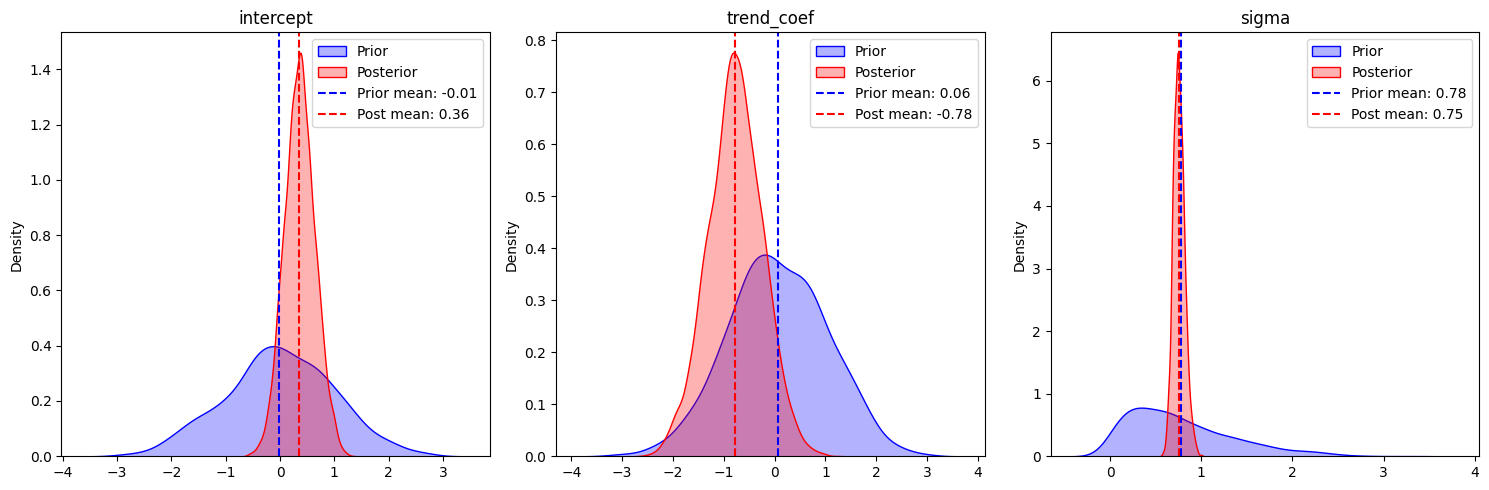

Sampling: [coef_spend_channel_1, coef_spend_channel_2, coef_spend_channel_3, coef_spend_channel_4, coef_spend_channel_5, coef_spend_channel_6, coef_spend_channel_7, decay_after_peak_spend_channel_6, decay_rate_spend_channel_1, decay_rate_spend_channel_2, decay_rate_spend_channel_3, decay_rate_spend_channel_4, decay_rate_spend_channel_5, decay_rate_spend_channel_6, decay_rate_spend_channel_7, delay_spend_channel_6, immediate_coef_spend_channel_7, immediate_weight_spend_channel_3, intercept, likelihood, long_term_coef_spend_channel_7, peak_spread_spend_channel_5, peak_week_spend_channel_5, peak_week_spend_channel_6, season_coefs, shape_spend_channel_7, sigma, time_factor_spend_channel_5, trend_coef]
Sampling: [likelihood]


Prior pred structure: <class 'arviz.data.inference_data.InferenceData'>
Prior pred keys: ['prior', 'prior_predictive', 'observed_data']
Posterior pred structure: <class 'arviz.data.inference_data.InferenceData'>
Posterior pred keys: ['posterior_predictive', 'observed_data']
Prior predictive keys: ['likelihood']
Using 'posterior_predictive' for posterior predictive
Error processing posterior predictive samples: unsupported operand type(s) for *: 'method' and 'float'
Prior revenue shape: (1, 100, 104)
Post revenue shape: (1, 104)


In [7]:
prior_stats, posterior_stats, summary_df = compare_prior_posterior(mmm, trace, revenue_mean, revenue_std, channel_cols, channel_configs)

In [8]:
def generate_prior_posterior_report(summary_df, channel_cols, channel_configs):
    """
    Generate a report comparing prior and posterior sampling results
    """
    # Start with markdown report
    report = """
# Prior vs Posterior Sampling Analysis for Bayesian MMM

## Overview
This report analyzes how our model results differ when using prior sampling versus posterior sampling. Prior samples represent our initial beliefs before seeing the data, while posterior samples represent our updated beliefs after conditioning on the observed data.

## Key Findings

"""
    # Add summary of biggest changes
    top_changes = summary_df.sort_values('Change_in_Mean', key=abs, ascending=False).head(3)
    report += "### Biggest Updates to Parameter Estimates\n\n"
    
    for _, row in top_changes.iterrows():
        param = row['Parameter']
        change = row['Change_in_Mean']
        direction = "increased" if change > 0 else "decreased"
        report += f"- **{param}**: {direction} by {abs(change):.3f} (Prior: {row['Prior_Mean']:.3f} → Posterior: {row['Posterior_Mean']:.3f})\n"
    
    # Add summary of uncertainty reduction
    top_uncertainty = summary_df.sort_values('Uncertainty_Reduction_%', ascending=False).head(3)
    report += "\n### Biggest Reductions in Uncertainty\n\n"
    
    for _, row in top_uncertainty.iterrows():
        param = row['Parameter']
        reduction = row['Uncertainty_Reduction_%']
        report += f"- **{param}**: Uncertainty reduced by {reduction:.1f}% (Prior std: {row['Prior_Std']:.3f} → Posterior std: {row['Posterior_Std']:.3f})\n"
    
    # Detailed analysis by parameter type
    report += "\n## Channel Coefficients Analysis\n\n"
    report += "Channel coefficients represent the effectiveness of each marketing channel in driving sales.\n\n"
    
    coef_rows = summary_df[summary_df['Parameter'].str.contains('coef_')]
    for _, row in coef_rows.iterrows():
        ch = row['Parameter'].replace('coef_', '')
        report += f"### {ch}\n\n"
        report += f"- **Prior**: Mean = {row['Prior_Mean']:.3f}, 95% HDI = {row['Prior_95%_HDI']}\n"
        report += f"- **Posterior**: Mean = {row['Posterior_Mean']:.3f}, 95% HDI = {row['Posterior_95%_HDI']}\n"
        report += f"- **Change**: {row['Change_in_Mean']:.3f} ({row['Change_in_Mean']/row['Prior_Mean']*100:.1f}% {'increase' if row['Change_in_Mean'] > 0 else 'decrease'})\n"
        report += f"- **Uncertainty Reduction**: {row['Uncertainty_Reduction_%']:.1f}%\n\n"
        
        # Add interpretation
        if abs(row['Change_in_Mean']) < 0.1 * row['Prior_Mean']:
            report += "**Interpretation**: The data largely confirmed our prior beliefs about this channel's effectiveness.\n\n"
        elif row['Change_in_Mean'] > 0:
            report += "**Interpretation**: This channel is more effective at driving sales than we initially believed.\n\n"
        else:
            report += "**Interpretation**: This channel is less effective at driving sales than we initially believed.\n\n"
    
    # Decay rates analysis
    report += "\n## Decay Rates Analysis\n\n"
    report += "Decay rates determine how quickly the effect of advertising diminishes over time.\n\n"
    
    decay_rows = summary_df[summary_df['Parameter'].str.contains('decay_rate_')]
    for _, row in decay_rows.iterrows():
        ch = row['Parameter'].replace('decay_rate_', '')
        config = channel_configs.get(ch, {})
        adstock_type = config.get('adstock_type', 'geometric')
        
        report += f"### {ch} ({adstock_type} adstock)\n\n"
        report += f"- **Prior**: Mean = {row['Prior_Mean']:.3f}, 95% HDI = {row['Prior_95%_HDI']}\n"
        report += f"- **Posterior**: Mean = {row['Posterior_Mean']:.3f}, 95% HDI = {row['Posterior_95%_HDI']}\n"
        report += f"- **Change**: {row['Change_in_Mean']:.3f} ({row['Change_in_Mean']/row['Prior_Mean']*100:.1f}% {'increase' if row['Change_in_Mean'] > 0 else 'decrease'})\n"
        report += f"- **Uncertainty Reduction**: {row['Uncertainty_Reduction_%']:.1f}%\n\n"
        
        # Add interpretation
        if row['Change_in_Mean'] > 0:
            report += "**Interpretation**: This channel's effects persist longer than we initially believed.\n\n"
        else:
            report += "**Interpretation**: This channel's effects decay more quickly than we initially believed.\n\n"
    
    # Model components analysis
    report += "\n## Core Model Parameters\n\n"
    
    other_params = summary_df[~summary_df['Parameter'].str.contains('coef_|decay_rate_')]
    for _, row in other_params.iterrows():
        param = row['Parameter']
        report += f"### {param}\n\n"
        report += f"- **Prior**: Mean = {row['Prior_Mean']:.3f}, 95% HDI = {row['Prior_95%_HDI']}\n"
        report += f"- **Posterior**: Mean = {row['Posterior_Mean']:.3f}, 95% HDI = {row['Posterior_95%_HDI']}\n"
        report += f"- **Change**: {row['Change_in_Mean']:.3f}\n"
        report += f"- **Uncertainty Reduction**: {row['Uncertainty_Reduction_%']:.1f}%\n\n"
    
    # Overall conclusions
    report += """
## Conclusions

The comparison between prior and posterior sampling reveals how our understanding of marketing effectiveness has evolved after incorporating the observed data. Key takeaways include:

1. **Information Gain**: On average, our uncertainty about model parameters decreased by {:.1f}% after conditioning on the data.

2. **Channel Effectiveness Updates**: The data has provided substantial updates to our beliefs about certain channels' effectiveness, particularly for {}, {}, and {}.

3. **Decay Dynamics**: Our understanding of how quickly advertising effects decay has been refined, with the biggest updates for {}, {}, and {}.

4. **Model Fit**: The posterior predictive check demonstrates that our model can reproduce the observed data much better after learning from it, compared to prior predictions which showed much wider variability.

This analysis highlights the value of the Bayesian approach in marketing mix modeling, as it allows us to incorporate prior knowledge while letting the data refine our understanding of marketing effectiveness.
""".format(
    summary_df['Uncertainty_Reduction_%'].mean(),
    *top_changes['Parameter'].iloc[:3].str.replace('coef_', ''),
    *decay_rows.sort_values('Change_in_Mean', key=abs, ascending=False)['Parameter'].iloc[:3].str.replace('decay_rate_', '')
)
    
    return report

# Generate and save the report
report = generate_prior_posterior_report(summary_df, channel_cols, channel_configs)
with open('prior_vs_posterior_analysis.md', 'w') as f:
    f.write(report)

print("Analysis complete. Report saved as 'prior_vs_posterior_analysis.md'")

Analysis complete. Report saved as 'prior_vs_posterior_analysis.md'


In [9]:
generate_prior_posterior_report(summary_df, channel_cols, channel_configs)


"\n# Prior vs Posterior Sampling Analysis for Bayesian MMM\n\n## Overview\nThis report analyzes how our model results differ when using prior sampling versus posterior sampling. Prior samples represent our initial beliefs before seeing the data, while posterior samples represent our updated beliefs after conditioning on the observed data.\n\n## Key Findings\n\n### Biggest Updates to Parameter Estimates\n\n- **trend_coef**: decreased by 0.835 (Prior: 0.058 → Posterior: -0.776)\n- **coef_spend_channel_1**: decreased by 0.752 (Prior: 0.782 → Posterior: 0.029)\n- **coef_spend_channel_4**: decreased by 0.752 (Prior: 0.796 → Posterior: 0.044)\n\n### Biggest Reductions in Uncertainty\n\n- **coef_spend_channel_1**: Uncertainty reduced by 95.2% (Prior std: 0.588 → Posterior std: 0.028)\n- **coef_spend_channel_4**: Uncertainty reduced by 93.3% (Prior std: 0.591 → Posterior std: 0.039)\n- **sigma**: Uncertainty reduced by 89.2% (Prior std: 0.581 → Posterior std: 0.063)\n\n## Channel Coefficients 

## Visualize Model Performance and Post-Processing 

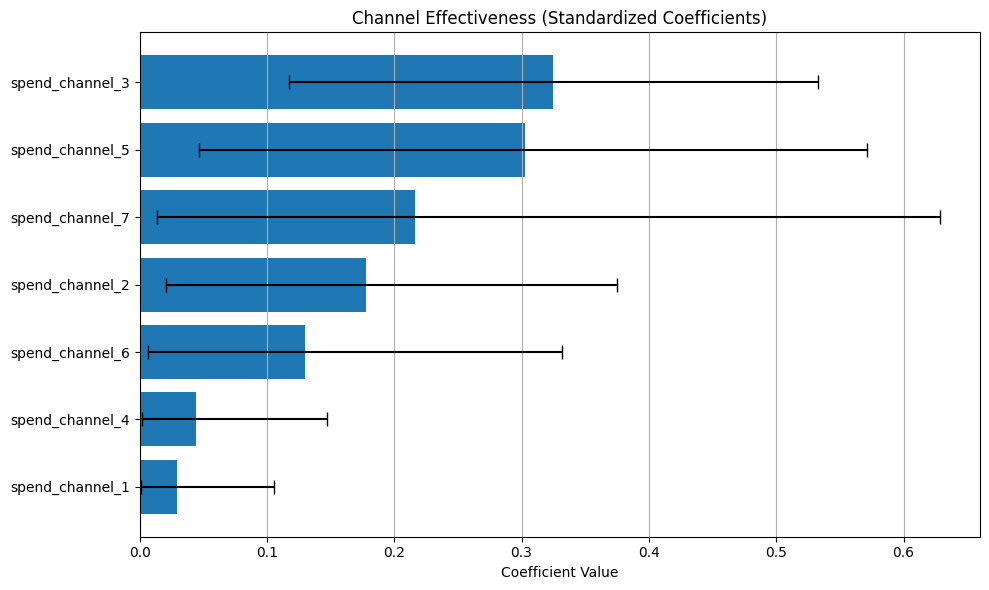

In [10]:
def plot_channel_effects(trace, channel_cols):
    """
    Plot the channel effects using the output from build_mmm_model_differentAdstoc_TimingImpact
    
    Parameters:
    - trace: InferenceData object from PyMC sampling
    - channel_cols: List of channel column names
    """
    # Extract coefficients from the trace
    channel_effects = {}
    
    # For each channel, get coefficient values from the trace
    for ch in channel_cols:
        # Get the coefficient samples for this channel
        coef_samples = trace.posterior[f"coef_{ch}"].values.flatten()
        
        # Calculate mean and 95% credible interval
        mean_coef = np.mean(coef_samples)
        ci_lower = np.percentile(coef_samples, 2.5)
        ci_upper = np.percentile(coef_samples, 97.5)
        
        # Store in dictionary
        channel_effects[ch] = {
            'mean_coefficient': mean_coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    
    # Now plot as in the original code
    channels = list(channel_effects.keys())
    coefs = [channel_effects[ch]['mean_coefficient'] for ch in channels]
    ci_lower = [channel_effects[ch]['ci_lower'] for ch in channels]
    ci_upper = [channel_effects[ch]['ci_upper'] for ch in channels]
    
    # Sort by coefficient value
    sorted_indices = np.argsort(coefs)
    sorted_channels = [channels[i] for i in sorted_indices]
    sorted_coefs = np.array([coefs[i] for i in sorted_indices])
    sorted_ci_lower = np.array([ci_lower[i] for i in sorted_indices])
    sorted_ci_upper = np.array([ci_upper[i] for i in sorted_indices])
    
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_channels, sorted_coefs)
    plt.xlabel('Coefficient Value')
    plt.title('Channel Effectiveness (Standardized Coefficients)')
    plt.grid(True, axis='x')
    
    # Add error bars
    plt.errorbar(
        sorted_coefs, 
        sorted_channels, 
        xerr=np.array([sorted_coefs - sorted_ci_lower, sorted_ci_upper - sorted_coefs]),
        fmt='none', 
        color='black', 
        capsize=5
    )
    plt.tight_layout()
    plt.show()
    
    return channel_effects

channel_effects = plot_channel_effects(trace, channel_cols)

## Obtain Performance Metrics

Model Performance Metrics:
Relative MAE: 0.19
Normalized RMSE: 0.25
R²: 0.527
MAPE: 18.68%


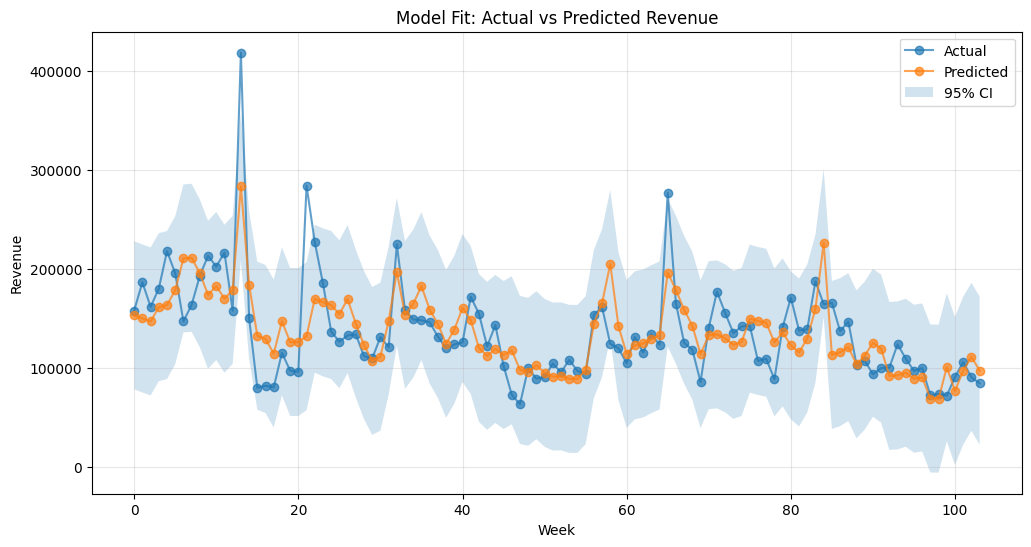

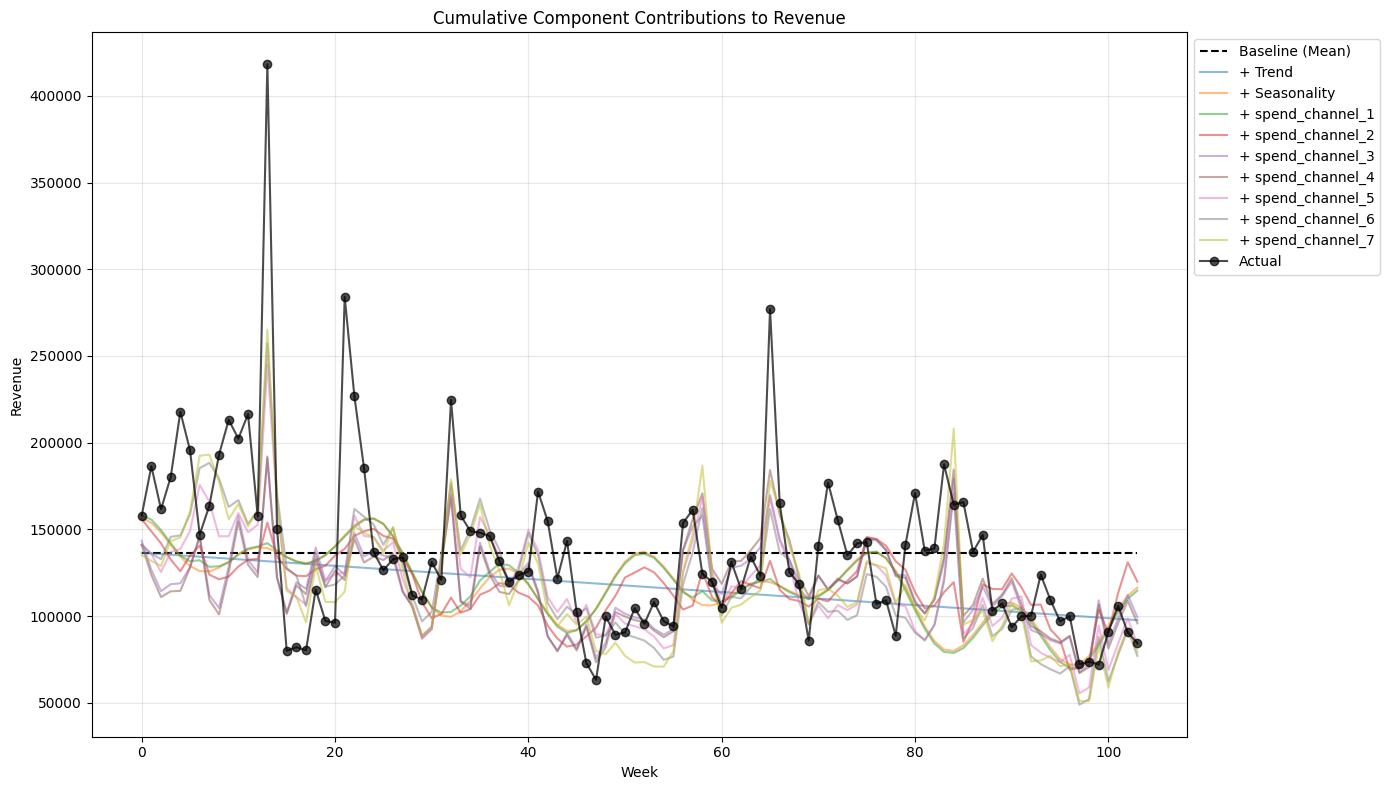

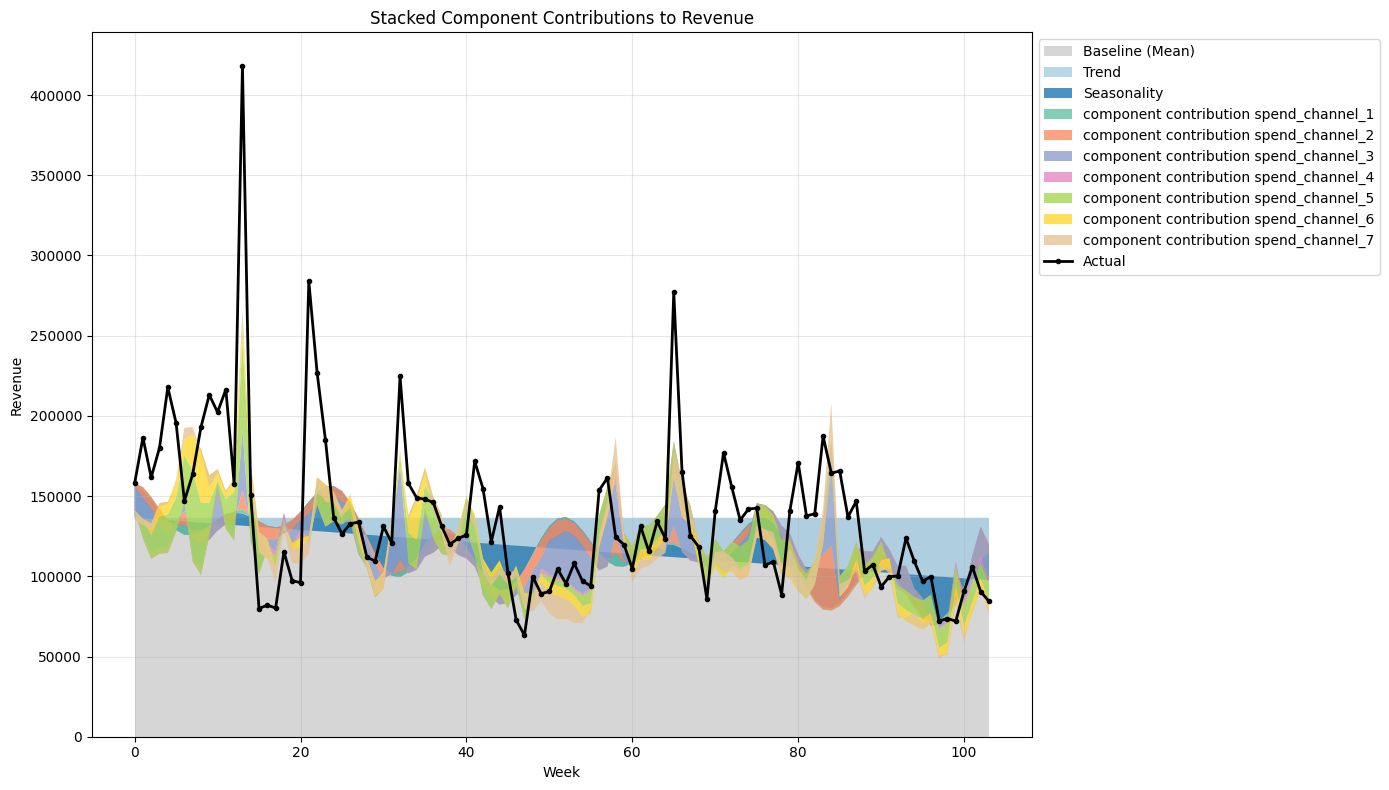

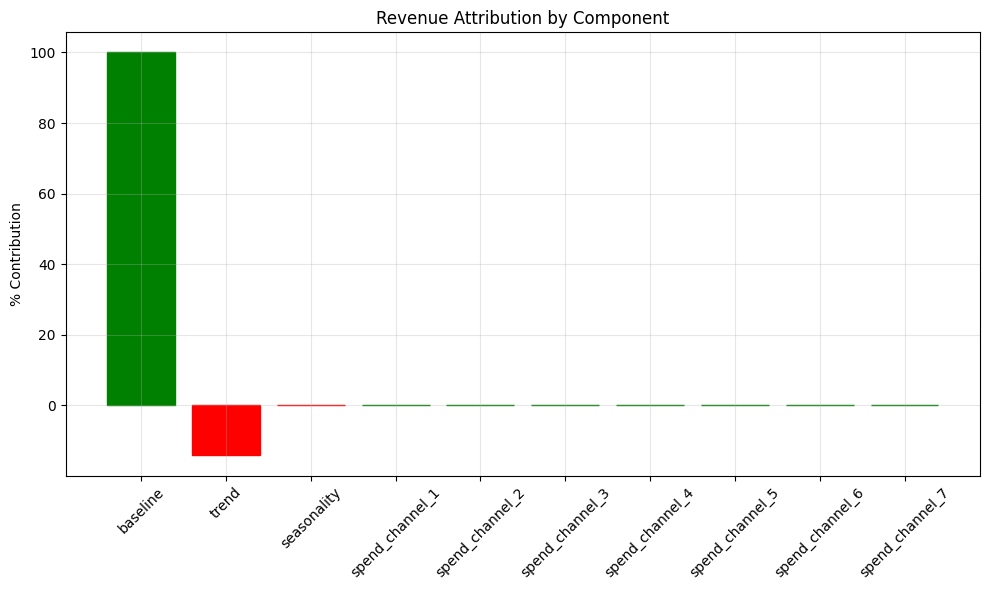

In [15]:
def evaluate_mmm(trace, data, channel_cols, channel_data, revenue_mean, revenue_std, decay_rates):
    """Evaluate MMM model performance and visualize contributions"""

    # Get posterior samples
    posterior = trace.posterior
    
    # 1. Model Predictions & Performance Metrics
    # ------------------------------------------
    # Prepare data for predictions
    n_weeks = len(data)
    week_num = np.array(data['week_num'])
    scaled_time = week_num / n_weeks
    
    # Seasonality features
    n_harmonics = 4
    seasonality_features = []
    for h in range(1, n_harmonics + 1):
        period = 52.0
        seasonality_features.extend([
            np.sin(2 * np.pi * h * week_num / period),
            np.cos(2 * np.pi * h * week_num / period)
        ])
    seasonality_features = np.column_stack(seasonality_features)
    
    # Extract posterior means
    posterior_means = {}
    for var in ['intercept', 'trend_coef', 'sigma']:
        posterior_means[var] = posterior[var].mean(dim=["chain", "draw"]).values
        
    posterior_means['season_coefs'] = posterior['season_coefs'].mean(dim=["chain", "draw"]).values
    
    for ch in channel_cols:
        posterior_means[f'coef_{ch}'] = posterior[f'coef_{ch}'].mean(dim=["chain", "draw"]).values
        posterior_means[f'decay_rate_{ch}'] = posterior[f'decay_rate_{ch}'].mean(dim=["chain", "draw"]).values
        posterior_means[f'effect_{ch}'] = posterior[f'effect_{ch}'].mean(dim=["chain", "draw"]).values
    
    # Calculate component contributions
    components = {}
    
    # Base components
    components['intercept'] = np.ones(n_weeks) * posterior_means['intercept']
    components['trend'] = scaled_time * posterior_means['trend_coef']
    components['seasonality'] = np.dot(seasonality_features, posterior_means['season_coefs'])
    
    # Channel effects - already extracted from posterior
    for ch in channel_cols:
        components[f'effect_{ch}'] = posterior_means[f'effect_{ch}']
    
    # Sum all components to get prediction (standardized)
    y_pred_std = components['intercept'] + components['trend'] + components['seasonality']
    for ch in channel_cols:
        y_pred_std += components[f'effect_{ch}']
    
    # Convert back to original scale
    y_pred = y_pred_std * revenue_std + revenue_mean
    y_true = data['revenue']
    
    # Calculate performance metrics  
    Relative_MAE = (mean_absolute_error(y_true, y_pred))/y_true.mean()
    Normalized_RMSE = (np.sqrt(mean_squared_error(y_true, y_pred)))/y_true.mean()
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    variance_explained = 1 - np.var(data['revenue'].values - y_pred) / np.var(data['revenue'].values)

    print(f"Model Performance Metrics:")
    print(f"Relative MAE: {Relative_MAE:.2f}")
    print(f"Normalized RMSE: {Normalized_RMSE:.2f}")
    print(f"R²: {r2:.3f}")
    print(f"MAPE: {mape:.2f}%")
    
    # 2. Visualization of Model Fit
    # -----------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(data['start_of_week'], y_true, 'o-', label='Actual', alpha=0.7)
    plt.plot(data['start_of_week'], y_pred, 'o-', label='Predicted', alpha=0.7)
    plt.fill_between(
        data['start_of_week'],
        y_pred - 1.96 * posterior_means['sigma'] * revenue_std,
        y_pred + 1.96 * posterior_means['sigma'] * revenue_std,
        alpha=0.2, label='95% CI'
    )
    plt.title('Model Fit: Actual vs Predicted Revenue')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Component Contribution Visualization
    # ---------------------------------------
    # Convert standardized contributions back to original scale
    for component in components:
        components[component] = components[component] * revenue_std
    
    # Stack plot of all components
    plt.figure(figsize=(14, 8))
    
    # Base components
    base = np.zeros(n_weeks) + revenue_mean
    plt.plot(data['start_of_week'], base, 'k--', label='Baseline (Mean)')
    
    # Stacked components
    stack = base.copy()
    
    # First stack trend and seasonality
    stack += components['trend']
    plt.plot(data['start_of_week'], stack, alpha=0.5, label='+ Trend')
    
    stack += components['seasonality']
    plt.plot(data['start_of_week'], stack, alpha=0.5, label='+ Seasonality')
    
    # Then stack each channel effect
    for ch in channel_cols:
        stack += components[f'effect_{ch}']
        plt.plot(data['start_of_week'], stack, alpha=0.5, label=f'+ {ch}')
    
    # Plot the actual data as well
    plt.plot(data['start_of_week'], y_true, 'o-', color='black', alpha=0.7, label='Actual')
    
    plt.title('Cumulative Component Contributions to Revenue')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    # 4. Prepare stack components
    # ------------------------------------
    # Plot staced component's contributions
    baseline = np.ones(n_weeks) * revenue_mean
    trend = components['trend']
    seasonality = components['seasonality']
    channels = [components[f'effect_{ch}'] for ch in channel_cols]

    # Stack in correct order (base, trend, seasonality, channels)
    stacked_components = [baseline, trend, seasonality] + channels
    labels = ['Baseline (Mean)', 'Trend', 'Seasonality'] + [f'component contribution {ch}' for ch in channel_cols]
    colors = ['#cccccc', '#a6cee3', '#1f78b4'] + list(plt.cm.Set2.colors[:len(channel_cols)])

    plt.figure(figsize=(14, 8))
    plt.stackplot(data['start_of_week'], stacked_components, labels=labels, colors=colors, alpha=0.8)

    # Plot actual revenue on top
    plt.plot(data['start_of_week'], y_true, 'k.-', label='Actual', linewidth=2)

    plt.title('Stacked Component Contributions to Revenue')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 5. Channel Attribution (% of Revenue)
    # -----------------------------------
    # Calculate the percentage contribution of each component
    total_predicted = y_pred.sum()
    attribution = {}
    
    # Calculate contribution percentages
    attribution['baseline'] = revenue_mean * n_weeks / total_predicted * 100
    attribution['trend'] = abs(components['trend'].sum()) / total_predicted * 100
    attribution['seasonality'] = abs(components['seasonality'].sum()) / total_predicted * 100
    
    for ch in channel_cols:
        attribution[ch] = abs(components[f'effect_{ch}'].sum()) / total_predicted * 100

    # Normalize to ensure the percentages sum to 100%
    total_attribution = sum(attribution.values())
    for key in attribution:
        attribution[key] = (attribution[key] / total_attribution) * 100
    
    # Visualize attribution
    plt.figure(figsize=(10, 6))
    labels = list(attribution.keys())
    values = [components[label].sum() if label in components else 
          (revenue_mean * n_weeks if label == 'baseline' else 0) 
          for label in labels]

    # Convert to percentage of total positive contribution
    total_positive = sum([v for v in values if v > 0])
    values_pct = [v / total_positive * 100 for v in values]
    
    bars = plt.bar(labels, values_pct)
    
    # Color bars based on positive/negative contribution
    for i, bar in enumerate(bars):
        bar.set_color('green' if values_pct[i] >= 0 else 'red')
    
    plt.title('Revenue Attribution by Component')
    plt.ylabel('% Contribution')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return all results for further analysis
    return {
        'metrics': {'Relative MAE': Relative_MAE, 'Normalized RMSE': Normalized_RMSE, 'r2': r2, 'mape': mape},
        'predictions': y_pred,
        'components': components,
        'attribution': attribution,
        'posterior_means': posterior_means
    }

evaluation_results = evaluate_mmm(trace, data, channel_cols, channel_data, revenue_mean, revenue_std, decay_rates)


## Analysis ROI

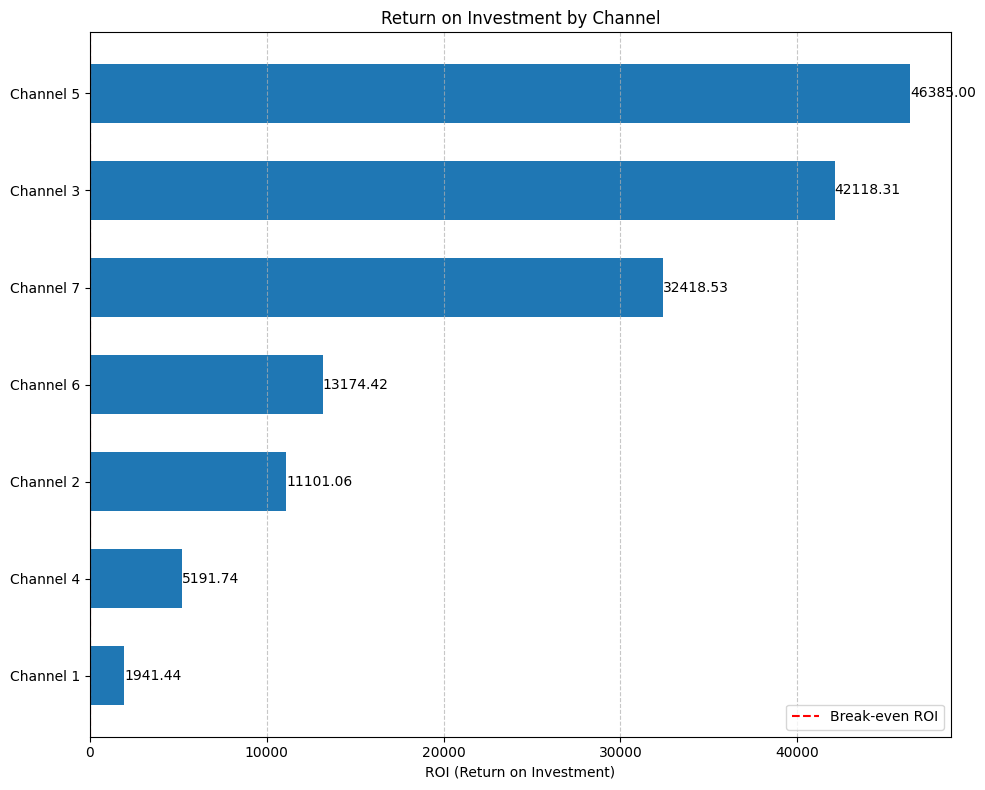

In [16]:
def plot_channel_roi(trace, channel_cols, channel_data, revenue_std):
    """Plot ROI comparison across channels"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get posterior means
    posterior = trace.posterior
    roi_values = []
    
    # Calculate ROI for each channel
    for ch in channel_cols:
        coef = posterior[f'coef_{ch}'].mean(dim=["chain", "draw"]).values
        decay_rate = posterior[f'decay_rate_{ch}'].mean(dim=["chain", "draw"]).values
        
        # Calculate ROI: coefficient * (1/(1-decay)) * revenue_std
        roi = coef * (1/(1-decay_rate)) * revenue_std
        roi_values.append(roi)
    
    # Create sorted data for visualization
    channel_names = [ch.replace('spend_channel_', 'Channel ') for ch in channel_cols]
    sorted_indices = np.argsort(roi_values)
    sorted_channels = [channel_names[i] for i in sorted_indices]
    sorted_roi = [roi_values[i] for i in sorted_indices]
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.barh(sorted_channels, sorted_roi, height=0.6)
    
    # Add value labels to the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width + 0.1
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{sorted_roi[i]:.2f}', 
                va='center')
    
    # Add break-even line
    ax.axvline(x=1.0, color='r', linestyle='--', label='Break-even ROI')
    
    # Add labels and title
    ax.set_xlabel('ROI (Return on Investment)')
    ax.set_title('Return on Investment by Channel')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.legend()
    
    # Ensure y-axis labels are fully visible
    plt.tight_layout()
    plt.show()

plot_channel_roi(trace, channel_cols, channel_data, revenue_std)

## Budget Allocation Optimization

In [17]:
##For optimal budget allocation:
def optimize_budget_allocation(trace, channel_cols, channel_data, revenue_std, current_budget=None):
    """Find optimal budget allocation across channels"""
    
    # Get posterior means
    posterior = trace.posterior
    posterior_means = {}
    
    for ch in channel_cols:
        posterior_means[f'coef_{ch}'] = posterior[f'coef_{ch}'].mean(dim=["chain", "draw"]).values
        posterior_means[f'decay_rate_{ch}'] = posterior[f'decay_rate_{ch}'].mean(dim=["chain", "draw"]).values
    
    # If no budget specified, use the sum of current average spends
    if current_budget is None:
        current_budget = sum(channel_data[ch]['mean'] for ch in channel_cols)
    
    # Define response function for a given spend allocation
    def channel_response(spend, channel):
        mean = channel_data[channel]['mean']
        std = channel_data[channel]['std']
        coef = posterior_means[f'coef_{channel}']
        decay_rate = posterior_means[f'decay_rate_{channel}']
        
        # Standardize spend
        spend_std = (spend - mean) / std if std > 0 else spend
        
        # Apply adstock and response
        response = coef * spend_std / (1 - decay_rate) * revenue_std
        return response
    
    # Objective function to maximize total response
    def objective(allocations):
        total_response = 0
        for i, ch in enumerate(channel_cols):
            spend = allocations[i]
            response = channel_response(spend, ch)
            total_response += response
        return -total_response  # Negative because we want to maximize
    
    # Constraint: sum of allocations equals budget
    def constraint(allocations):
        return sum(allocations) - current_budget
    
    # Initial allocation (equal split)
    initial_allocation = np.ones(len(channel_cols)) * current_budget / len(channel_cols)
    
    # Bounds: non-negative spend
    bounds = [(0, None) for _ in channel_cols]
    
    # Solve optimization problem
    constraints = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_allocation, method='SLSQP', 
                      bounds=bounds, constraints=constraints)
    
    optimal_allocation = result.x
    
    # Create comparison table
    current_allocation = np.array([channel_data[ch]['mean'] for ch in channel_cols])
    current_response = np.array([channel_response(current_allocation[i], ch) 
                                 for i, ch in enumerate(channel_cols)])
    optimal_response = np.array([channel_response(optimal_allocation[i], ch) 
                                 for i, ch in enumerate(channel_cols)])
    
    comparison = pd.DataFrame({
        'Channel': channel_cols,
        'Current Spend': current_allocation,
        'Optimal Spend': optimal_allocation,
        'Change %': (optimal_allocation - current_allocation) / current_allocation * 100,
        'Current Response': current_response,
        'Optimal Response': optimal_response,
        'Response Lift %': (optimal_response - current_response) / current_response * 100
    })
    
    # Visualize comparison
    import matplotlib.pyplot as plt
    
    # Plot current vs optimal allocation
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(channel_cols))
    width = 0.35
    
    plt.bar(x - width/2, current_allocation, width, label='Current')
    plt.bar(x + width/2, optimal_allocation, width, label='Optimal')
    
    plt.xlabel('Channel')
    plt.ylabel('Budget Allocation')
    plt.title('Current vs. Optimal Budget Allocation')
    plt.xticks(x, channel_cols)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return results
    return {
        'comparison': comparison,
        'current_total_response': sum(current_response),
        'optimal_total_response': sum(optimal_response),
        'total_lift': (sum(optimal_response) - sum(current_response)) / sum(current_response) * 100
    }

/home/coder/tmp/ipykernel_306489/2077384087.py:71: RuntimeWarning: divide by zero encountered in divide
  'Response Lift %': (optimal_response - current_response) / current_response * 100


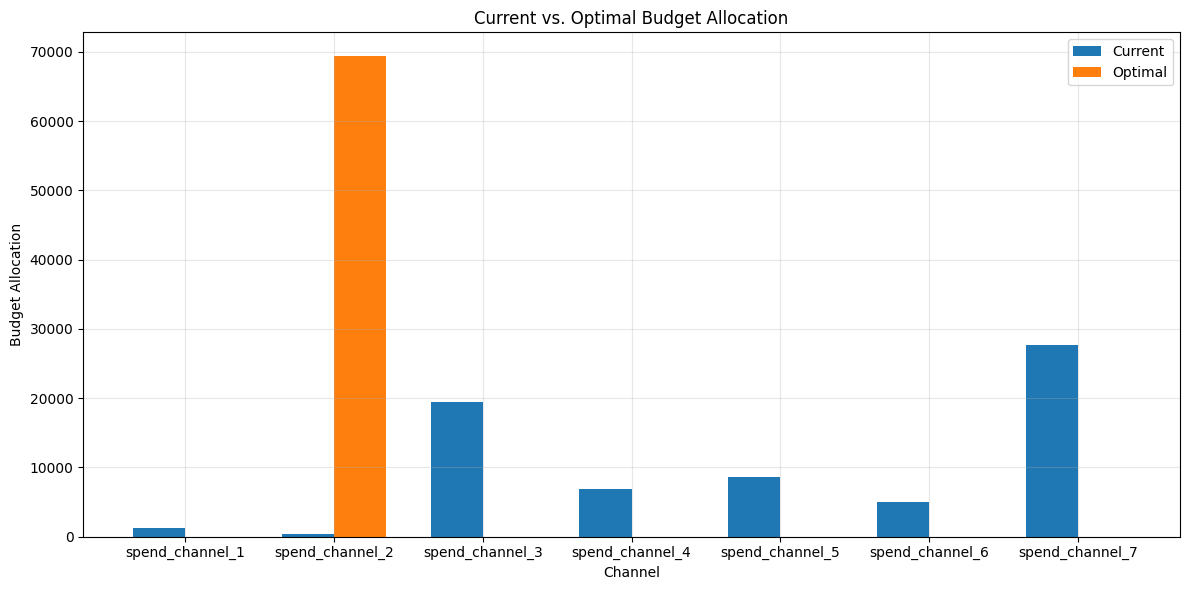


Budget Optimization Summary:
Total Response Lift: inf%

Optimal Allocation:
           Channel  Current Spend  Optimal Spend      Change %
0  spend_channel_1    1245.604808       0.000000   -100.000000
1  spend_channel_2     343.640962   69352.238365  20081.598275
2  spend_channel_3   19507.177981       0.000000   -100.000000
3  spend_channel_4    6915.136731       0.000000   -100.000000
4  spend_channel_5    8575.611442       0.000000   -100.000000
5  spend_channel_6    5063.699038       0.000000   -100.000000
6  spend_channel_7   27701.367404       0.000000   -100.000000


/home/coder/tmp/ipykernel_306489/2077384087.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  'total_lift': (sum(optimal_response) - sum(current_response)) / sum(current_response) * 100


In [18]:
# Budget optimization
optimization = optimize_budget_allocation(trace, channel_cols, channel_data, revenue_std)
    
print("\nBudget Optimization Summary:")
print(f"Total Response Lift: {optimization['total_lift']:.2f}%")
print("\nOptimal Allocation:")
print(optimization['comparison'][['Channel', 'Current Spend', 'Optimal Spend', 'Change %']])
    


## Conclusion

This notebook has demonstrated a Bayesian approach to Marketing Mix Modeling. The analysis provides insights into:

1. The effectiveness of each marketing channel (coefficient size)
2. The persistence of marketing effects over time (decay rates)
3. The return on investment for each channel

